In [ ]:
# Import modules

import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.linalg import inv
from numpy.linalg import slogdet
from scipy.optimize import minimize

import pandas as pd
from math import log10
from matplotlib.colors import ListedColormap

In [ ]:
from astropy.io import fits
from astropy.table import Table, hstack, vstack

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
data = np.load('/content/drive/MyDrive/Colab Notebooks/spec64000newz.npz')

In [ ]:
with fits.open('/content/drive/MyDrive/Colab Notebooks/full_zok_w1w2.fits') as hdu_list:
  photo = Table.read(hdu_list[1])

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

# Aligning photo with spectro

In [ ]:
list(photo.keys())  

['MJD',
 'PLATE',
 'FIBERID',
 'RA',
 'DEC',
 'Z',
 'ZWARNING',
 'CLASS',
 'SUBCLASS',
 'FLUX_G',
 'FLUX_IVAR_G',
 'MW_TRANSMISSION_G',
 'FLUX_R',
 'FLUX_IVAR_R',
 'MW_TRANSMISSION_R',
 'FLUX_Z',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_Z',
 'FLUX_W1',
 'FLUX_IVAR_W1',
 'MW_TRANSMISSION_W1',
 'FLUX_W2',
 'FLUX_IVAR_W2',
 'MW_TRANSMISSION_W2']

In [ ]:
data_plate = data['plate']
data_mjd = data['mjd']
data_fiber = data['fiber']

photo_plate = photo['PLATE']
photo_mjd = photo['MJD']
photo_fiber = photo['FIBERID']
photo_class = photo['CLASS']
photo_subclass = photo['SUBCLASS']
photo_fluxg = photo['FLUX_G']
photo_fluxr = photo['FLUX_R']
photo_fluxz = photo['FLUX_Z']
photo_fluxw1 = photo['FLUX_W1']
photo_fluxw2 = photo['FLUX_W2']
photo_z = photo['Z']

In [ ]:
# Select galaxies from both data sets

class_ind = photo_class == 'GALAXY'

photo_plate = photo_plate[class_ind]
photo_mjd = photo_mjd[class_ind]
photo_fiber = photo_fiber[class_ind]
photo_class = photo_class[class_ind]
photo_subclass = photo_subclass[class_ind]
photo_fluxg = photo_fluxg[class_ind]
photo_fluxr = photo_fluxr[class_ind]
photo_fluxz = photo_fluxz[class_ind]
photo_fluxw1 = photo_fluxw1[class_ind]
photo_fluxw2 = photo_fluxw2[class_ind]
photo_z = photo_z[class_ind]

print(np.shape(photo_plate))

galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]
data_plate = data_plate[galaxy_ind]
data_mjd = data_mjd[galaxy_ind]
data_fiber = data_fiber[galaxy_ind]
mask = data['mask'][galaxy_ind]

print(np.shape(data_plate))

(2541424,)
(62978,)


In [ ]:
# Match photo data to spectro

data_ind = np.array([0])
for i in range(len(data_plate)):
  ind = np.flatnonzero((photo_plate == data_plate[i]) & (photo_mjd == data_mjd[i]) & (photo_fiber == data_fiber[i]))
  data_ind = np.concatenate([data_ind,ind])

data_ind = np.delete(data_ind,0)

photo_plate = photo_plate[data_ind]
photo_mjd = photo_mjd[data_ind]
photo_fiber = photo_fiber[data_ind]
photo_class = photo_class[data_ind]
photo_subclass = photo_subclass[data_ind]
photo_fluxg = photo_fluxg[data_ind]
photo_fluxr = photo_fluxr[data_ind]
photo_fluxz = photo_fluxz[data_ind]
photo_fluxw1 = photo_fluxw1[data_ind]
photo_fluxw2 = photo_fluxw2[data_ind]
photo_z = photo_z[data_ind]

In [ ]:
# Match spectro data to photo

photo_ind = np.array([0])
for i in range(len(photo_plate)):
  ind = np.flatnonzero((data_plate == photo_plate[i]) & (data_mjd == photo_mjd[i]) & (data_fiber == photo_fiber[i]))
  photo_ind = np.concatenate([photo_ind,ind])

photo_ind = np.delete(photo_ind,0)
print(np.shape(photo_ind))

X = X[photo_ind]
subclass = subclass[photo_ind]
z = z[photo_ind]
z_err = z_err[photo_ind]
spec_err = spec_err[photo_ind]
data_plate = data_plate[photo_ind]
data_mjd = data_mjd[photo_ind]
data_fiber = data_fiber[photo_ind]
mask = mask[photo_ind]

plate_mjd_fiber = np.column_stack((data_plate, data_mjd, data_fiber))

(62640,)


In [ ]:
print(np.shape(photo_fluxw1))
print(np.shape(photo_fluxw2))

(62640,)
(62640,)


In [ ]:
photo_subclass_num = np.zeros(np.shape(photo_subclass))

AGN_ind = photo_subclass=='AGN'
photo_subclass_num[AGN_ind] = 0
AGN_broad_ind = photo_subclass=='AGN BROADLINE'
photo_subclass_num[AGN_broad_ind] = 1
broad_ind = photo_subclass=='BROADLINE'
photo_subclass_num[broad_ind] = 2
starburst_ind = photo_subclass=='STARBURST'
photo_subclass_num[starburst_ind] = 3
starforming_ind = photo_subclass=='STARFORMING'
photo_subclass_num[starforming_ind] = 4
star_broad_ind = photo_subclass=='STARFORMING BROADLINE'
photo_subclass_num[star_broad_ind] = 5
none_ind = photo_subclass == ' '
photo_subclass_num[none_ind] = 6

photo_subclass_names = ['AGN','AGN BROADLINE','BROADLINE','STARBURST','STARFORMING','STARFORMING BROADLINE']
photo_subclass_names_all = ['AGN','AGN BROADLINE','BROADLINE','STARBURST','STARFORMING','STARFORMING BROADLINE','NONE']

In [ ]:
subclass_names = []
for i in subclass:
  if i == 2:
    subclass_names.append('ABSORPTION')
  elif i == 3:
    subclass_names.append('NORMAL')
  elif i == 4:
    subclass_names.append('EMISSION LINE')
  elif i == 5:
    subclass_names.append('NARROW-LINE QSO')

In [ ]:
subclass_names_alone = ['ABSORPTION','NORMAL','EMISSION LINE','NARROW-LINE-QSO']

# Data pre-processing

Number of capped errors 263722


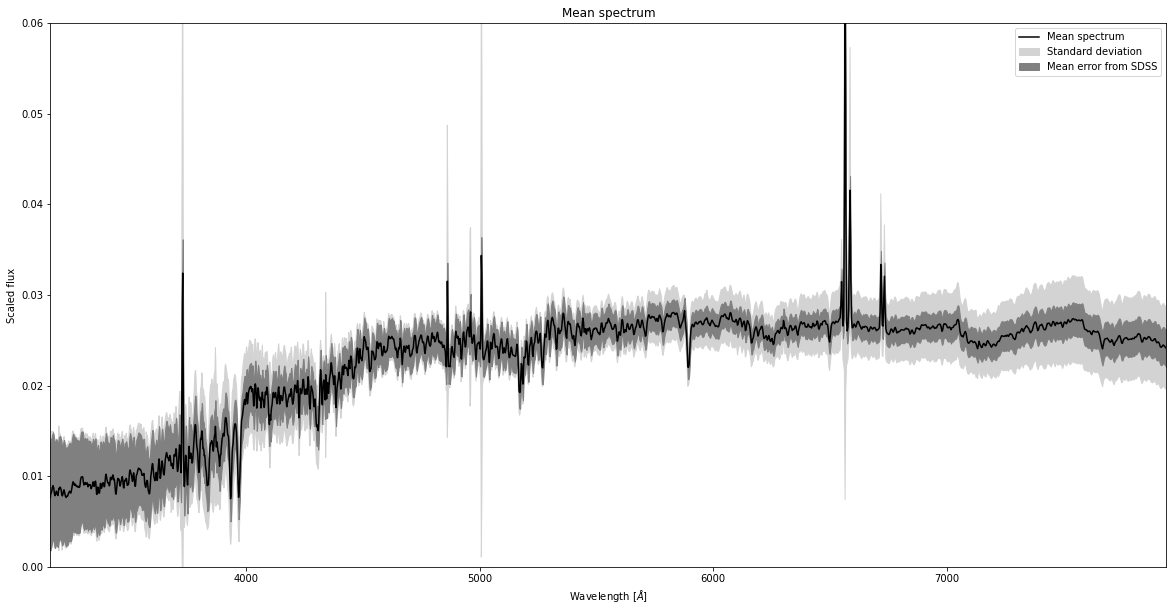

In [ ]:
#%% Calculating wavlength grid from coefficients

log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, X.shape[1], 1)
wavelengths = [10**i for i in log_wavelengths]

#%% Selecting only galaxies (spec_cln = 2)

#galaxy_ind = data['spec_cln'] == 2
#X = data['spectra'][galaxy_ind]
#subclass = data['lineindex_cln'][galaxy_ind]
#z = data['z'][galaxy_ind]
#z_err = data['zerr'][galaxy_ind]
#spec_err = data['spec_err'][galaxy_ind]

#%% Set any negative spikes in flux to zero and set the corresponding error to zero

neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

#%% Set zero fluxes to NaN

X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

#%% Set all zero and negative flux errors to NaN

zero_err_ind = spec_err <= 0.
spec_err[zero_err_ind] = np.NaN

#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

#%% Plot an example spectrum in the data
#plt.figure()
#plt.plot(wavelengths,X_normal[4])
#plt.show()

#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)
#spec_err_norm_copy = spec_err_norm.copy()

# %% Cap errors at a lower limit of 1e-3 times the flux
# cap_counter = 0
# for spectra in range(len(spec_err_norm)):
#     for pixel in range(len(spec_err_norm[spectra])):
#         if np.isnan(spec_err_norm[spectra][pixel]) == False and spec_err_norm[spectra][pixel] < 1e-3 * X_normal[spectra][pixel]:
#             spec_err_norm[spectra][pixel] = 1e-3 * X_normal[spectra][pixel]
#             cap_counter += 1
# print("Number of capped errors", cap_counter)

# %% NEW WAY OF CAPPING ERRORS
spec_err_norm_flattened = spec_err_norm.flatten()
X_normal_flattened = X_normal.flatten()
spec_err_norm_cap_ind = np.flatnonzero(~np.isnan(spec_err_norm_flattened))
X_normal_scaled3 = X_normal_flattened[~np.isnan(spec_err_norm_flattened)] * 1e-3
cap_counter1 = np.flatnonzero(spec_err_norm_flattened[~np.isnan(spec_err_norm_flattened)] < X_normal_scaled3)
for i in cap_counter1:
  spec_err_norm_flattened[spec_err_norm_cap_ind[i]] = X_normal_flattened[spec_err_norm_cap_ind[i]] * 1e-3
spec_err_norm = spec_err_norm_flattened.reshape(X_normal.shape)
print("Number of capped errors", cap_counter1.size)

#%% Spectra errors with infs instead of nans
spec_err_norm_inf = np.nan_to_num(spec_err_norm,nan=np.inf)

# Mask where errors are infinite
mask_err = np.zeros(np.shape(spec_err_norm), dtype=bool)
spec_err_inf_ind = spec_err_norm_inf == np.inf
mask_err[spec_err_inf_ind] = True

# Include mask from spectroscopy data
mask_err[mask] = True
spec_err_norm_inf[mask] = np.inf
spec_err_norm[mask] = np.nan

#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

# Iterative PCA

In [ ]:
!pip install astroML

In [ ]:
from astroML.dimensionality import iterative_pca

In [ ]:
_, mu_iter2, evecs2, evals2, _, iter_coeffs2 = iterative_pca(X_norm_zeros, mask_err, n_ev=2, n_iter=20, norm='L2', full_output=True)
_, mu_iter4, evecs4, evals4, _, iter_coeffs4 = iterative_pca(X_norm_zeros, mask_err, n_ev=4, n_iter=20, norm='L2', full_output=True)
_, mu_iter6, evecs6, evals6, _, iter_coeffs6 = iterative_pca(X_norm_zeros, mask_err, n_ev=6, n_iter=20, norm='L2', full_output=True)
_, mu_iter8, evecs8, evals8, _, iter_coeffs8 = iterative_pca(X_norm_zeros, mask_err, n_ev=8, n_iter=20, norm='L2', full_output=True)
_, mu_iter10, evecs10, evals10, _, iter_coeffs10 = iterative_pca(X_norm_zeros, mask_err, n_ev=10, n_iter=20, norm='L2', full_output=True)

In [ ]:
np.savez('iterative_2.npz', mu_iter2=mu_iter2, evecs2=evecs2, evals2=evals2, iter_coeffs2=iter_coeffs2)
np.savez('iterative_4.npz', mu_iter4=mu_iter4, evecs4=evecs4, evals4=evals4, iter_coeffs4=iter_coeffs4)
np.savez('iterative_6.npz', mu_iter6=mu_iter6, evecs6=evecs6, evals6=evals6, iter_coeffs6=iter_coeffs6)
np.savez('iterative_8.npz', mu_iter8=mu_iter8, evecs8=evecs8, evals8=evals8, iter_coeffs8=iter_coeffs8)
np.savez('iterative_10.npz', mu_iter10=mu_iter10, evecs10=evecs10, evals10=evals10, iter_coeffs10=iter_coeffs10)

# Standard PCA

In [ ]:
pca2 = PCA(n_components=2, random_state=0)
X_red2 = pca2.fit_transform(X_norm_zeros)
np.savez('standard_2.npz', X_red2=X_red2, pca2mean=pca2.mean_, pca2components=pca2.components_)

In [ ]:
pca4 = PCA(n_components=4, random_state=0)
X_red4 = pca4.fit_transform(X_norm_zeros)
np.savez('standard_4.npz', X_red4=X_red4, pca4mean=pca4.mean_, pca4components=pca4.components_)

In [ ]:
pca6 = PCA(n_components=6, random_state=0)
X_red6 = pca6.fit_transform(X_norm_zeros)
np.savez('standard_6.npz', X_red6=X_red6, pca6mean=pca6.mean_, pca6components=pca6.components_)

In [ ]:
pca8 = PCA(n_components=8, random_state=0)
X_red8 = pca8.fit_transform(X_norm_zeros)
np.savez('standard_8.npz', X_red8=X_red8, pca8mean=pca8.mean_, pca8components=pca8.components_)

In [ ]:
pca10 = PCA(n_components=10, random_state=0)
X_red10 = pca10.fit_transform(X_norm_zeros)
np.savez('standard_10.npz', X_red10=X_red10, pca10mean=pca10.mean_, pca10components=pca10.components_)

# Switch to hosted runtime

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  
import jax
from jax.interpreters import xla
xla._xla_callable.cache_clear()

from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, vmap, device_put, partial
from jax.ops import index, index_update

# Load iterative PCA data

In [ ]:
with np.load('iterative_2.npz') as file_name:
    mu_iter2 = file_name['mu_iter2']
    evecs2 = file_name['evecs2']
    evals2 = file_name['evals2']
    iter_coeffs2 = file_name['iter_coeffs2']

In [ ]:
with np.load('iterative_4.npz') as file_name:
    mu_iter4 = file_name['mu_iter4']
    evecs4 = file_name['evecs4']
    evals4 = file_name['evals4']
    iter_coeffs4 = file_name['iter_coeffs4']

In [ ]:
with np.load('iterative_6.npz') as file_name:
    mu_iter6 = file_name['mu_iter6']
    evecs6 = file_name['evecs6']
    evals6 = file_name['evals6']
    iter_coeffs6 = file_name['iter_coeffs6']

In [ ]:
with np.load('iterative_8.npz') as file_name:
    mu_iter8 = file_name['mu_iter8']
    evecs8 = file_name['evecs8']
    evals8 = file_name['evals8']
    iter_coeffs8 = file_name['iter_coeffs8']

In [ ]:
with np.load('iterative_10.npz') as file_name:
    mu_iter10 = file_name['mu_iter10']
    evecs10 = file_name['evecs10']
    evals10 = file_name['evals10']
    iter_coeffs10 = file_name['iter_coeffs10']

# Bayesian PCA functions

## Bayesian PCA

In [ ]:
def sig_inv_diag_all(spec_err_norm_inf):
  sig_inv_diag_arr = spec_err_norm_inf ** (-2)
  log_sig = np.log(sig_inv_diag_arr)
  log_sig[log_sig == -np.inf] = 0.
  logdet_sig_arr = np.array([np.sum(i) for i in log_sig])
  return sig_inv_diag_arr, logdet_sig_arr

In [ ]:
sig_inv_diag_arr, logdet_sig_inv_arr = sig_inv_diag_all(spec_err_norm_inf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def ln_onespec(W,ident, X_mu_zeros_n, sig_inv_diag, logdet_sig_inv):
  sig_inv_W = sig_inv_diag[:,None]*W

  M = ident + jnp.matmul(W.T, sig_inv_W)
  M_inv = jnp.linalg.solve(M,ident)
  _, logdet_M = jnp.linalg.slogdet(M)

  W_sig = sig_inv_W.T
  W_sig_X = jnp.matmul(W_sig, X_mu_zeros_n)
  Minv_W_sig_X = jnp.matmul(M_inv, W_sig_X)
  Cinv_2 = jnp.matmul(sig_inv_W, Minv_W_sig_X)
  Cinv_1 = sig_inv_diag*X_mu_zeros_n
  Cinv_X = Cinv_1 - Cinv_2
    
  l_n = -0.5*X_mu_zeros_n.shape[0]*jnp.log(2*jnp.pi) -0.5*(logdet_M - logdet_sig_inv) -0.5*jnp.matmul(X_mu_zeros_n.T, Cinv_X)  

  return l_n

In [ ]:
def ln_allspec(W, data1):
  ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr = data1
  W = W[0]
  return -sum(vmap(ln_onespec, in_axes=(None,None,0,0,0))(W, ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr))

In [ ]:
from jax.experimental import optimizers

def optimise(W,learning_rate,num_iterations):
  param_list = [1*W]
  opt_init, opt_update, get_params = jax.experimental.optimizers.adam(learning_rate)
  opt_state = opt_init(param_list)
  
  @jit
  def update(step, opt_state, data1):
    params = get_params(opt_state)
    value, grads = jax.value_and_grad(ln_allspec)(params,data1)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state
    
  ln = []
  data1 = (jnp.identity(W.shape[1]), jnp.array(X_mu_zeros), jnp.array(sig_inv_diag_arr), jnp.array(logdet_sig_inv_arr))
  for step in range(num_iterations):
    ln_value, opt_state = update(step, opt_state, data1)
    ln.append(ln_value)
  
  # optimised matrix:
  W_new_optimised = get_params(opt_state)
  return W_new_optimised[0], ln

In [ ]:
def optimise_batched(W,learning_rate,num_iterations, X_mu_zeros_n):
  param_list = [1*W]
  opt_init, opt_update, get_params = jax.experimental.optimizers.adam(learning_rate)
  opt_state = opt_init(param_list)
  
  @jit
  def update(step, opt_state, data1):
    params = get_params(opt_state)
    value, grads = jax.value_and_grad(ln_allspec)(params,data1)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

  batch_size = 2000  
  ln = []
  for step in range(num_iterations):
    ln_iter = 0
    for batch in range(32):
      data1 = (jnp.identity(W.shape[1]),jnp.array(X_mu_zeros_n[batch*batch_size:(batch+1)*batch_size]), jnp.array(sig_inv_diag_arr[batch*batch_size:(batch+1)*batch_size]), jnp.array(logdet_sig_inv_arr[batch*batch_size:(batch+1)*batch_size]))
      ln_value, opt_state = update(step, opt_state, data1)
      ln_iter += ln_value
    ln.append(ln_iter)
  
  # optimised matrix:
  W_new_optimised = get_params(opt_state)
  return W_new_optimised[0], ln

## Bayesian coeffs

In [ ]:
# Function to retrieve PCA coefficients from a PCA
def bayesian_coeffs(W, X_mu_zeros_n, sig_inv_diag, ident):
  W_siginv_X = np.matmul(W.T,sig_inv_diag*X_mu_zeros_n)
  M = np.matmul(W.T, sig_inv_diag[:, None]*W) + ident
  z_map = np.linalg.solve(M, W_siginv_X)
  return z_map

In [ ]:
# Retrieve coefficients for all arrays
def bayesian_coeffs_all(W_new, X_mu_zeros):
  W_optimised_arr = np.asarray(W_new)
  coeffs_optimised = np.zeros(np.shape(W_new)[1])
  for i in range(X_mu_zeros.shape[0]):
    coeffs_optimised = np.vstack((coeffs_optimised, bayesian_coeffs(W_optimised_arr, X_mu_zeros[i],sig_inv_diag_arr[i], jnp.identity(W_new.shape[1]))))
  coeffs_optimised = np.delete(coeffs_optimised, 0, 0)
  return coeffs_optimised

# Run Bayesian PCA

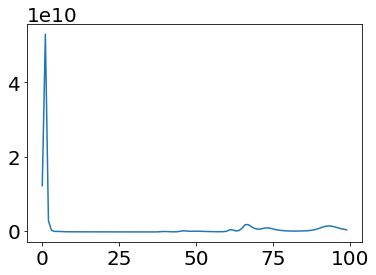

In [ ]:
W2 = evecs2[:2].T
X_mu_zeros2 = np.nan_to_num(X_normal - mu_iter2,nan=0.)
W2_new_lr4, ln2_lr4 = optimise_batched(W2,learning_rate = 1e-4,num_iterations = 100, X_mu_zeros_n=X_mu_zeros2)
coeffs2 = bayesian_coeffs_all(W2_new_lr4, X_mu_zeros2)
plt.plot(ln2_lr4)

In [ ]:
np.savez('bayesian_2.npz', X_mu_zeros2=X_mu_zeros2, W2_new_lr4=W2_new_lr4, ln2_lr4=ln2_lr4, coeffs2=coeffs2)

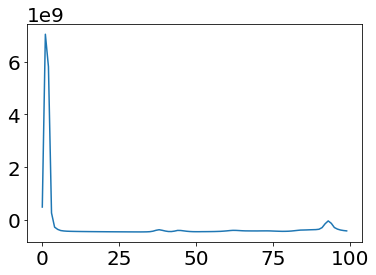

In [ ]:
W4 = evecs4[:4].T
X_mu_zeros4 = np.nan_to_num(X_normal - mu_iter4,nan=0.)
W4_new_lr4, ln4_lr4 = optimise_batched(W4,learning_rate = 1e-4,num_iterations = 100, X_mu_zeros_n=X_mu_zeros4)
coeffs4 = bayesian_coeffs_all(W4_new_lr4, X_mu_zeros4)
plt.plot(ln4_lr4)

In [ ]:
np.savez('bayesian_4.npz', X_mu_zeros4=X_mu_zeros4, W4_new_lr4=W4_new_lr4, ln4_lr4=ln4_lr4, coeffs4=coeffs4)

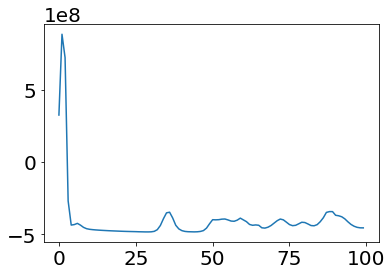

In [ ]:
W6 = evecs6[:6].T
X_mu_zeros6 = np.nan_to_num(X_normal - mu_iter6,nan=0.)
W6_new_lr4, ln6_lr4 = optimise_batched(W6,learning_rate = 1e-4,num_iterations = 100, X_mu_zeros_n=X_mu_zeros6)
coeffs6 = bayesian_coeffs_all(W6_new_lr4, X_mu_zeros6)
plt.plot(ln6_lr4)

In [ ]:
np.savez('bayesian_6.npz', X_mu_zeros6=X_mu_zeros6, W6_new_lr4=W6_new_lr4, ln6_lr4=ln6_lr4, coeffs6=coeffs6)

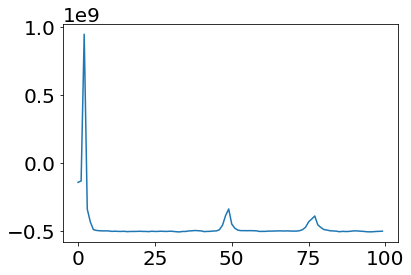

In [ ]:
W8 = evecs8[:8].T
X_mu_zeros8 = np.nan_to_num(X_normal - mu_iter8,nan=0.)
W8_new_lr4, ln8_lr4 = optimise_batched(W8,learning_rate = 1e-4,num_iterations = 100, X_mu_zeros_n=X_mu_zeros8)
coeffs8 = bayesian_coeffs_all(W8_new_lr4, X_mu_zeros8)
plt.plot(ln8_lr4)

In [ ]:
np.savez('bayesian_8.npz', X_mu_zeros8=X_mu_zeros8, W8_new_lr4=W8_new_lr4, ln8_lr4=ln8_lr4, coeffs8=coeffs8)

In [ ]:
W10 = evecs10[:10].T
X_mu_zeros10 = np.nan_to_num(X_normal - mu_iter10,nan=0.)
W10_new_lr4, ln10_lr4 = optimise_batched(W10,learning_rate = 1e-4,num_iterations = 100, X_mu_zeros_n=X_mu_zeros10)
coeffs10 = bayesian_coeffs_all(W10_new_lr4, X_mu_zeros10)

In [ ]:
np.savez('bayesian_10.npz', X_mu_zeros10=X_mu_zeros10, W10_new_lr4=W10_new_lr4, ln10_lr4=ln10_lr4, coeffs10=coeffs10)